In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import torch.nn.init as init

from PF import *

In [2]:
"""
Parameter initialization
"""

# Set noise seed
noise_seed = np.random.randint(10000)
print('noise_seed =',noise_seed)
np.random.seed(seed=noise_seed)

#8933

# -------------------- Initialize the parameters -------------------- 
Nx  = 5       # No. of variables
Nr  = 2*Nx    # No. of neurons
Nh  = 1 + Nx  # No. of external input variables

T   = 1000  # No. of time steps
Tc  = 20    # Extra time steps added to data. Thes first 20 time steps will be clipped after training the RNN.
Th  = 2     # No. of time steps for which h is the same
Ns  = 1     # No. of batches
lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

nltype = 'sigmoid' # external nonlinearity in TAP dynamics

# Noise covariances 
Qpr = 1e-5*np.eye(Nx) # process noise
Qobs = 0e-4*np.eye(Nr) # use zero measurement noise to train the RNN; Subsequently, the approximation error of the RNN will act as measurement noise

# Initialize ground truth parameters

G = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters corresponding to the TAP equation

Jtype = 'nonferr'
sc_J = 1 # 1 : self coupling ON, 0: OFF
if Nx <= 4:
    sp_J = 0.1 # sparsity in J
else:
    sp_J = 0.3 # sparsity in J
    
J = 3*Create_J(Nx, sp_J, 'Jtype', sc_J) # Coupling matrix  


U = 2/Nr*np.random.randn(Nr,Nx) # embedding matrix

V = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # input embedding matrix

# concatenate the parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

noise_seed = 5646


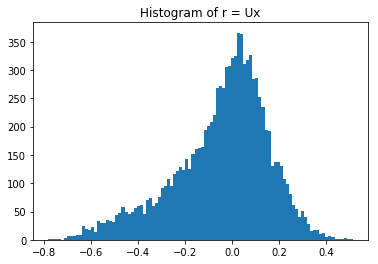

In [3]:
"""
Generate the latent dynamics and observations
"""

# Inputs parameter settings
gh = 25/np.sqrt(Nx) # gain for inputs h
hMatFull = np.zeros([Nh,T+Tc,Ns]) 

# Initial conditions for latent dynamics
x0Full = np.random.rand(Nx,Ns) # initial x

# Initialize arrays to save dynamics
xMatFull = np.zeros([Nx,T+Tc+1,Ns])
rMatFull = np.zeros([Nr,T+Tc,Ns])

# Filter used for smoothing the input signals
b = signal.hamming(5,sym=True) 
b = b/sum(b)

for s in range(Ns):
    hMatFull[:,:,s] = signal.filtfilt(b,1,generateBroadH(Nh,T+Tc,Th,gh))
    xMatFull[:,:,s], rMatFull[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta, nltype)


# Plot histogram of the data
plt.hist(rMatFull.flatten(),100)
plt.title('Histogram of r = Ux')
plt.show()


In [4]:
"""
Convert ground truth dynamics data to torch tensor
"""    
hMatFull = torch.tensor(hMatFull,dtype=torch.float32)
xMatFull = torch.tensor(xMatFull,dtype=torch.float32)
rMatFull = torch.tensor(rMatFull,dtype=torch.float32)

In [5]:
"""
Define the RNN model, loss function and optimizer
"""
rnn = nn.RNN(Nh, hidden_size=Nr, num_layers=2, nonlinearity='tanh')
print(rnn)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(),lr=0.002, betas=(0.9, 0.999))

RNN(6, 10, num_layers=2)


In [6]:
"""
Train RNN to fit direct embedding of TAP dynamics - rMatFull
"""

for epoch in range(2000):
    optimizer.zero_grad()
    # output, hn = rnn(hMatFull.permute(1,2,0))
    output = rnn(hMatFull.permute(1,2,0))[0]
    loss = loss_fn(output,rMatFull.permute(1,2,0))
    loss.backward()
    optimizer.step()
    
    if epoch % 250 == 249:
        print('[%d] loss: %.5f' %(epoch + 1, loss.item()))

print('Finished training')

[250] loss: 0.00711
[500] loss: 0.00223
[750] loss: 0.00119
[1000] loss: 0.00076
[1250] loss: 0.00059
[1500] loss: 0.00048
[1750] loss: 0.00036
[2000] loss: 0.00029
Finished training


In [7]:
"""
Convert required torch tensors to numpy arrays for running PF-EM code
"""

xMatFull = xMatFull.data.numpy()
hMatFull = hMatFull.data.numpy()
rMatFull = rMatFull.data.numpy()
rhatFull = output.permute(2,0,1).data.numpy() # output of rnn will be the measurements we use for the particle EM

del output

# remove the first 20 samples from the data
xMatFull = xMatFull[:,Tc:,:]
hMatFull = hMatFull[:,Tc:,:]
rMatFull = rMatFull[:,Tc:,:]
rhatFull = rhatFull[:,Tc:,:]

In [17]:
# Add some independent noise
rhatFull = rhatFull + np.sqrt(loss.item())*np.random.randn(Nr,T,Ns)

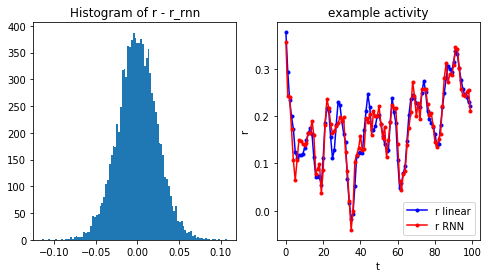

In [20]:
"""
look at the distribution of r - r_rnn
"""

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].hist((rMatFull - rhatFull).flatten(),100)
ax[0].set_title('Histogram of r - r_rnn')
ax[1].plot(rMatFull[0,0:100,0],'b.-')
ax[1].plot(rhatFull[0,0:100,0],'r.-')
ax[1].set(xlabel='t', ylabel='r', title ='example activity')
ax[1].legend(['r linear', 'r RNN'])
plt.show()

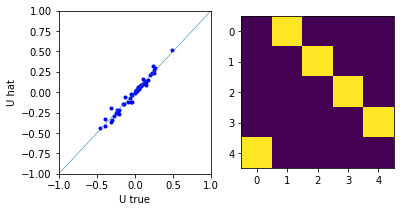

In [21]:
"""
Use ICA to get initial estimate of the embedding from the latent dynamics
"""

U_1 = UhatICA(np.reshape(rhatFull,[Nr,T*Ns],order='F').T, Nx, U)[0]

# Estimate the permutation matrix P (need this to resolve permutation ambiguity of ICA)
P = EstimatePermutation_ICA(U,U_1)

# Plot estimate of embedding and permutation matrix
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(U.flatten(),np.dot(U_1,P).flatten(),'b.')
r = np.ceil(np.max(np.abs(U)))
ax[0].plot([-r,r],[-r,r],Linewidth=0.5)
ax[0].axis([-r,r,-r,r])
ax[0].set(xlabel='U true', ylabel='U hat')
ax[1].imshow(P)
plt.show()

In [22]:
"""
Run the particle filter on the neural activity using the ground truth parameters 
to obtain the data log likelihood.
"""

# Pick only a subset of the data. 
# We used a lot more data to obtain the initial estimate of the embedding using ICA. 
# We will use a subset of the data for the particle filter - EM
TTotal = 500 # Total no. of time steps to use for analysis
T = TTotal//Ns

# Pick only the required subset and discard the rest
rMatFull = rMatFull[:,0:T,:]
hMatFull = hMatFull[:,0:T,:]
xMatFull = xMatFull[:,0:T+1,:]
rhatFull = rhatFull[:,0:T,:]

# ---------  Run the particle filter with true values of (G, J, U, V) --------
Qobs = loss.item()*np.eye(Nr) # measurement noise
K = 100                              # No. of particles

x_truedec = np.zeros([Nx,T+1,Ns])    # decoded latent dynamics using ground truth parameters
P_truedec = np.zeros([Nx,K,T+1,Ns])  # dynamics of individual particles
r_truedec = np.zeros([Nr,T,Ns])      # fit to measurements using ground truth parameters
W_truedec = np.zeros([K,Ns])         # weights of each particles
LL        = np.zeros([Ns])           # data log-likelihood for each session

for s in range(Ns):
    LL[s],x_truedec[:,:,s], P_truedec[:,:,:,s], W_truedec[:,s] = particlefilter(rhatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta, nltype)
    r_truedec[:,:,s] = np.dot(U,x_truedec[:,1:,s])

print('Log likelihood with true params = ',LL.mean())

Log likelihood with true params =  -4922.804738127666


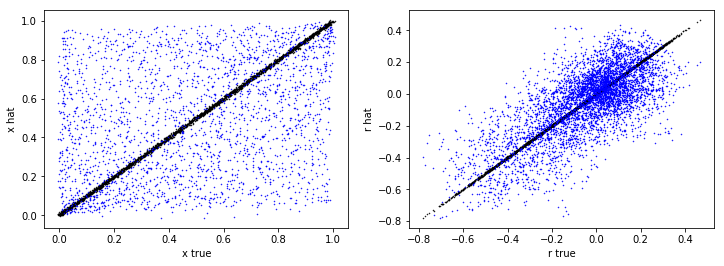

Log likelihood before EM =  -125041.49150912682


In [23]:
"""
Initialize the parameters for PF-EM
"""

lam_1 = np.array([0.25])                # use ground truth low pass filtering constant

G_1 = 0.1*np.random.randn(18)           # init for message passing parameters 
J_1 = Create_J(Nx, sp_J, 'Jtype', sc_J) # init for coupling matrix
                                        # init for embedding matrix was obtained using ICA 
V_1 = np.linalg.svd(np.random.randn(Nx,Nh), full_matrices=False)[2] # init for the input mapping V

# Initialize the arrays for latent dynamics, fits to meausurements, particles, 
# particle weights and data log-likelihoods obtained using current values of the parameters

x_1 = np.zeros([Nx,T+1,Ns])
r_1 = np.zeros([Nr,T,Ns])
P_1 = np.zeros([Nx,K,T+1,Ns])
W_1 = np.zeros([K,Ns])
L_1 = np.zeros([Ns])


theta_1 = np.concatenate([lam_1, G_1, JMatToVec(J_1), U_1.flatten('F'), V_1.flatten('F') ])

# Run the PF using initial estimates of the parameters
for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rhatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])
    

st = 6 #discard the first st samples for plotting

# Plot comparison of latent states decoded by the PF using initial value of parameters vs. ground truth
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(xMatFull[:,st:,:].flatten(),x_truedec[:,st:,:].flatten(),'k.',markersize=1)
ax[0].plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'b.',markersize=1)
ax[0].set(xlabel='x true', ylabel='x hat')

ax[1].plot(rMatFull[:,st:,:].flatten(),r_truedec[:,st:,:].flatten(),'k.',markersize=1)
ax[1].plot(rMatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'b.',markersize=1)
ax[1].set(xlabel='r true', ylabel='r hat')
plt.show()


# Record the initial values of the required parameters and arrays
xinit = x_1*1.0
rinit = r_1*1.0

Jinit = J_1*1.0
Ginit = G_1*1.0
Uinit = U_1*1.0
Vinit = V_1*1.0
lam_init = lam_1*1.0

#del x_truedec, r_truedec, P_truedec, W_truedec

print('Log likelihood before EM = ',L_1.mean())

In [28]:
"""
Run the particle EM algorithm
"""

# Run the PF-EM on mini-batches of the entire data. Each batch comprises a subset of sessions. 
# (Right now, each mini-batch can comprise just one individual session. I might have to update this to handle multiple sessions)

idx     = np.random.randint(Ns)
rB      = rhatFull[:,:,idx]      # pick the observations for the mini batch
hB      = hMatFull[:,:,idx]      # pick the input signals for the mini batch 
P_B     = P_1[:,:,:,idx]
W_B     = W_1[:,idx]

EMIters = 200                 # maximum no. of iterations to use for the EM algorithm
MStepMaxIter = 10            # Maximum no. of iterations used by the optimizer in the M step
LMat   = np.zeros([EMIters]) # record how the log-likelihood changes with iterations

computegrad = np.array([1,1,0,1,0],dtype=int) # Flags which indicate which variables are updated in the order: G, J, U, V, lam

# We keep the Uhat fixed for the first 20% of EM iterations and update the rest. After that, we update all the parameters together.
# Right now, I am just running the EM algorithm for EMIters no. of iterations. Instead I need to run till convergence.

for iterem in range(EMIters):
    
    if iterem == EMIters//5:
        computegrad = [1, 1, 1, 1, 0]

    if iterem % 50 == 49:
        print('iterem =', iterem + 1)  
    
    MStep = optimize.minimize(NegLL, theta_1, args = (rB, hB, P_B, W_B, Qpr, Qobs, nltype, computegrad), method='BFGS', jac = NegLL_D, options={'disp': False,'maxiter':MStepMaxIter})
    theta_1 = MStep.x
        
    # E step: Pick a new batch and run the particle filter with the updated parameters    
    idx     = np.random.randint(Ns)
    rB      = rMatFull[:,:,idx] # pick the observations for the mini batch
    hB      = hMatFull[:,:,idx]
    
    LMat[iterem], x_B, P_B, W_B = particlefilter(rB, hB, K, Qpr, Qobs, theta_1, nltype)
    

# Extract parameters
lam_1, G_1, J_1, U_1, V_1 = extractParams(theta_1, 18, Nx, Nh, Nr)

# Run the PF with new parameters on all the batches
for s in range(Ns):
    L_1[s],x_1[:,:,s], P_1[:,:,:,s], W_1[:,s] = particlefilter(rMatFull[:,:,s], hMatFull[:,:,s], K, Qpr, Qobs, theta_1, nltype)
    r_1[:,:,s] = np.dot(U_1,x_1[:,1:,s])

In [29]:
"""
Plotting results
"""

print('Ghat =', G_1)

fig, ax = plt.subplots(1,3,figsize=(15,4))

ax[0].plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(x_1[:,st:,:],[Nx,Ns*(T+1-st)])).flatten(),'r.',markersize=1)
ax[0].plot([0,1],[0,1],linewidth=0.5)
ax[0].set(xlabel='xtrue', ylabel='xhat')
ax[1].plot(rhatFull[:,st:,:].flatten(),r_1[:,st:,:].flatten(),'r.',markersize=1)
ax[1].plot([-1,1],[-1,1],linewidth=0.5)
ax[1].set(xlabel='rtrue', ylabel='rhat')
ax[2].plot(np.arange(EMIters),LMat,'b.-',markersize=1)
ax[2].plot([0,EMIters],[LL.mean(), LL.mean()],'r')
ax[2].set(xlabel='iterations', ylabel='Log likelihood')
plt.show()

Jhat = J_1*0
Jinit_s = Jinit*0 # shuffle Jinit also
x_idx = np.dot(P.T,np.arange(Nx))

for ii in range(Nx):
    for jj in range(Nx):
        Jhat[ii,jj] = J_1[np.int(x_idx[ii]),np.int(x_idx[jj])]
        Jinit_s[ii,jj] = Jinit[np.int(x_idx[ii]),np.int(x_idx[jj])]
                          

fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(U.flatten(),np.dot(Uinit,P).flatten(),'b.')
ax[0].plot(U.flatten(),np.dot(U_1,P).flatten(),'r.')
ax[0].plot([-.6,.6],[-.6,.6],linewidth=0.5)
ax[0].set(xlabel='U true', ylabel='U hat')
ax[0].legend(['init', 'post EM'])

ax[1].plot(V.flatten(),np.dot(P.T,Vinit).flatten(),'b.')
ax[1].plot(V.flatten(),np.dot(P.T,V_1).flatten(),'r.')
ax[1].plot([-.8,.8],[-.8,.8],linewidth=0.5)
ax[1].set(xlabel='V true', ylabel='V hat')
ax[1].legend(['init', 'post EM'])

ax[2].plot(JMatToVec(J),JMatToVec(Jinit_s),'b.')
ax[2].plot(JMatToVec(J),JMatToVec(Jhat),'r.')
ax[2].plot([-1,1],[-1,1],linewidth=0.5)
ax[2].set(xlabel='J true', ylabel='J hat')
ax[2].legend(['init', 'post EM'])
plt.show()

In [26]:
"""
run dynamics with new set of parameters on training inputs and compare
"""

xMatFull_1 = np.zeros([Nx,T+1,Ns])
for s in range(Ns):
    xMatFull_1[:,:,s] = runTAP(x0Full[:,s], hMatFull[:,:,s], Qpr, Qobs, theta_1, nltype)[0]

st = 5
plt.plot(xMatFull[:,st:,:].flatten(), np.dot(P.T,np.reshape(xMatFull_1[:,st:,:],[Nx,Ns*(T-st+1)])).flatten(),'k.',markersize=1)
plt.title('Training data performance')
plt.xlabel('x with true params')
plt.ylabel('x with inferred params')
plt.axis('square')
plt.show()

In [27]:
"""
run dynamics with new set of parameters on test inputs and compare
""" 
xtest_true = np.zeros([Nx,T+1,Ns]) # to be generated using ground truth parameters
xtest_inf = np.zeros([Nx,T+1,Ns])  # to be generated using inferred parameters

x0test = np.random.rand(Nx,Ns) # initial x for test data

# test inputs
hMatFull_test = np.zeros([Nh,T,Ns]) # inputs h

for s in range(Ns):
    hMatFull_test[:,:,s] = signal.filtfilt(b,1,generateBroadH(Nh,T,Th,gh))
    xtest_true[:,:,s] = runTAP(x0test[:,s], hMatFull_test[:,:,s], Qpr, Qobs, theta, nltype)[0]
    xtest_inf[:,:,s] = runTAP(x0test[:,s], hMatFull_test[:,:,s], Qpr, Qobs, theta_1, nltype)[0]

st = 5
plt.plot(xtest_true[:,st:,:].flatten(), np.dot(P.T,np.reshape(xtest_inf[:,st:,:],[Nx,Ns*(T-st+1)])).flatten(),'k.',markersize=1)
plt.title('Test data performance')
plt.xlabel('x with true params')
plt.ylabel('x with inferred params')
plt.axis('square')
plt.show()

In [15]:
# # for saving variables
# mdict1={'xMatFull': xMatFull, 'xinit': xinit, 'x_1': x_1, 'hMatFull': hMatFull, 'rhatFull': rhatFull, 'rinit': rinit, 'r_1':r_1}

# mdict2={'P': P, 'J': J, 'G': G, 'U': U, 'V': V, 'Jinit': Jinit, 'Ginit': Ginit, 'Uinit': Uinit, 'Vinit': Vinit, 'J_1': J_1, 'G_1': G_1, 'U_1': U_1, 'V_1':V_1}

# mdict3={'P_1': P_1, 'W_1': W_1, 'LL': LL, 'L_1': L_1}

# scipy.io.savemat('data/Nx10_data.mat', mdict1)
# scipy.io.savemat('data/Nx10_params.mat', mdict2)
# scipy.io.savemat('data/Nx10_test.mat', mdict3)